# MD trajectory analysis: an exmaple with 6J83 protein system

## The 6J83 system
We will first have a quick glance at the 6J83 system. The system contains a protein, which has a single chain, two non-standard residues (HEM and CYM), and a substrate (IND). The system also contains water and ions. A 200ns molecular dynamics simulation has been performed using this system.

One can have a look at the system
* **Amber topology file** `./6j83/6j83_solv.prmtop` (which records information like structure connectivity, force constant, etc.)
* **Original trajectory** `./6j83/6j83_mdtraj.nc`
* Amber coordinate file `./6j83/6j83_solv.inpcrd` (not useful in this tutorial, just for reference)
* PDB file `./6j83/6j83_solve.pdb`, which has the same coordinate as `./6j83/6j83_solv.inpcrd`

The following code block calls py3Dmol to view the `./6j83/6j83_solv.pdb`.

In [1]:
import py3Dmol
with open("./6j83/6j83_solv.pdb") as f:
    system = f.read()                      # read pdb and save as string
view = py3Dmol.view(width=800, height=500) # initiate a 800x500 window
view.addModelsAsFrames(system, 'pdb')      # parse the string as pdb
view.setViewStyle(                         # set view style
    {'style': 'outline', 
     'color': 'black', 
     'width': 0.05}
)
view.setStyle(                             # set style for the backbone
    {'resi': '1-392'}, 
    {'cartoon': {'color': 'spectrum'}}
);
view.setStyle(                             # set style for non-standard residues
    {'resn': ["HEM", "IND", "CYM"]}, 
    {'stick': {'radius': .2}}
 );
view.setStyle(                             # set style for water molecules
    {'resn': ["WAT"]}, 
    {'stick': {'radius': .1}, 
     'sphere': {'scale': 0.04}}
);
view.setStyle(                             # set style for Na+
    {'resn': ["Na+"]}, 
    {'stick': {'radius': .1}, 
     'sphere': {'scale': 0.1}}
);
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Trajectory pre-processing
The MD trajectory cannot be directly used for analysis. Why? First, the raw trajectory **DOES NOT** follow the periodic boundary condition (PBC). It can cause a problem in visualization. Second, the protein has translational and rotational motion. These motions will cause a disaster when applying statistical algorithms directly to the 3D coordinate data, while they have no effect on molecular distances, bending angles, and dihedral angles (think about why).

Briefly, to view the trajectory and perform analysis, we need to do two things
1. Map all atoms **INTO** the box
1. Remove the translational and rotational motions of the protein

To align the trajectory, we can use cpptraj from AmberTools. The input command for cpptraj and descriptions are written in `./6j83/align.in`. One can change the directory to `./6j83` and then call cpptraj to perform the alignment.
```bash
cd 6j83
cpptraj align.in
```
To accelerate computation, one may also use a parallelized version of cpptraj, such as cpptraj.cuda, cpptraj.MPI, and cpptraj.OMP.

In [2]:
# have a look on ./6j83/align.in
!cat ./6j83/align.in

parm ./6j83_solv.prmtop          # input amber topology file
trajin 6j83_mdtraj.nc            # input trajectory
center :394                      # center the trajectory wrt to which part
                                 # residue 394 in this case
image                            # map all residues back to the periodic box
align :1-392                     # align all frames wrt to which part
trajout ./6j83_mdtraj_aligned.nc # specify output filename


In [3]:
# perform alignment (which is same as commands above)
!cd ./6j83 && cpptraj.cuda align.in | tail -16 # only print the last 16 lines

RUN TIMING:
TIME:		Init               : 0.0000 s (  0.00%)
TIME:		Trajectory Process : 1.9124 s ( 99.97%)
TIME:		Action Post        : 0.0000 s (  0.00%)
TIME:		Analysis           : 0.0000 s (  0.00%)
TIME:		Data File Write    : 0.0000 s (  0.00%)
TIME:		Other              : 0.0006 s (  0.00%)
TIME:	Run Total 1.9130 s
---------- RUN END ---------------------------------------------------
TIME: Total execution time: 1.9772 seconds.
--------------------------------------------------------------------------------
To cite CPPTRAJ use:
Daniel R. Roe and Thomas E. Cheatham, III, "PTRAJ and CPPTRAJ: Software for
  Processing and Analysis of Molecular Dynamics Trajectory Data". J. Chem.
  Theory Comput., 2013, 9 (7), pp 3084-3095.



Loading original and aligend trajectory into VMD, we can see the difference

Original trajectory:

<img src="./images/6j83_mdtraj.gif" width="50%">

Aligned trajectory:

<img src="./images/6j83_mdtraj_aligned.gif" width="50%">

## Load packages
First, we need to import several packages
* mdtraj: MD trajectory operations
* matplotlib: plot figures
* numpy: array computations
* scikit-learn: statistical and machine learning models, PCA in this tutorial

In [4]:
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
mpl.rcParams['lines.linewidth'] = 0.7          # set default linewidth
%config InlineBackend.figure_formats = ['svg'] # output the image in svg vector format which
                                               # could be clearer than image (png) format

## Load trajectory into Python as ndarray
Using mdtraj package in Python, we are able to convert MD trajectory coordinates to a three-dimensional array $D$. Note that $n$ denotes the number of frames, $N$ denotes the number of atoms

$$
D = \begin{bmatrix}
\mathbf{f}^{(1)} & \mathbf{f}^{(2)} & \cdots & \mathbf{f}^{(n)}
\end{bmatrix}, \mathbf{f}_i = 
\begin{bmatrix}
    a^{(1)}_x & a^{(2)}_x & \cdots & a^{(N)}_x \\
    a^{(1)}_y & a^{(2)}_y & \cdots & a^{(N)}_y \\
    a^{(1)}_z & a^{(2)}_z & \cdots & a^{(N)}_z 
\end{bmatrix}
$$

To load the MD trajectory, we need topology file for structural information such as atom types and connectivity. This is achieved by loading `.prmtop` file and `.nc` file simultaneously.

According to the cell below, we can know that in this case, $D\in\mathbb{R}^{500\times 48806\times 3}$.

In [5]:
top_6j83 = "./6j83/6j83_solv.prmtop"                           # topology file
traj_ = md.load("./6j83/6j83_mdtraj_aligned.nc", top=top_6j83) # load trajectory with topology
top = traj_.topology                                           # get topology
time_ = np.linspace(0, 200, traj_.xyz.shape[0])                # 200ns simulation
print("Shape of array", traj_.xyz.shape)
print("The system contains {} atoms and there are {} frames.".format(
    traj_.xyz.shape[1],
    traj_.xyz.shape[0]
))

Shape of array (500, 48806, 3)
The system contains 48806 atoms and there are 500 frames.


## Select residues/atoms
Sometimes we only want to perform analysis on some specific atoms. For example, protein backbond, heavy atoms of the substrate, some specific residues, etc. To extract trajectory data of these selected atoms, we need their atom indices. The selection syntax to select atoms is similar to VMD. The following lines provide some examples, and one can refer to the mdtraj documentation.

In [14]:
## atom selection
# select atoms
IND_idx      = top.select("resname IND and not element H")                       # heavy atoms in IND
backbone_idx = top.select("backbone")                                            # protein backbone
hbond1       = top.select('resname IND and name OAV or resid 162 and name O')    # IND:OAV-PHE163:O
hbond2       = top.select('resname IND and name OAV or resid 380 and name NE2')  # IND:OAV-GLN381:NE2
hbond3       = top.select('resname IND and name O or resid 483 and name O')      # IND-HOH484:O
FeON         = top.select('resname HEM and name OX or resname IND and name NAG') # Heme O(Fe) and IND indole N
FeO          = top.select('resname HEM and name OX or resname HEM and name FE')  # Heme Fe and O
FeS          = top.select('resname HEM and name FE or resname CYM and name SG')  # Heme Fe and CYM S
Fe           = top.select('resname HEM and name FE')                             # Heme Fe
N4           = top.select('resname HEM and name NA NB NC ND')                    # Heme N(Fe), total four of them

# have a look on the result
print("The Fe atom has the index {}.".format(Fe[0]))
IND_idx

The Fe atom has the index 6266.


array([6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278,
       6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6308])

## RMSD analysis
The atom selection makes it possible to compute the RMSD value of specific atom groups. We can call `md.rmsd` to perform the analysis.
```python
md.rmsd(target, reference, frame=0, atom_indices=None, parallel=True, precentered=False)
```

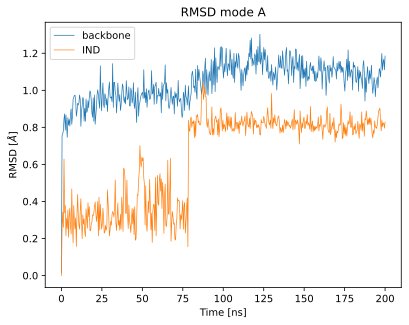

In [7]:
## RMSD analysis
# compute RMSD
backbone_rmsd = md.rmsd(traj_, traj_, 0, backbone_idx) # compute RMSD of backbone
IND_rmsd      = md.rmsd(traj_, traj_, 0, IND_idx)      # compute RMSD of IND

# plot the result
plt.plot(time_, backbone_rmsd * 10, label="backbone")  # *10 factor for converting nm to angstrom
plt.plot(time_, IND_rmsd * 10, label="IND")
plt.xlabel("Time [ns]")
plt.ylabel(r"RMSD [$\AA$]")
plt.title("RMSD mode A")
plt.legend()
plt.show()

## Get atom-pair distances
This is mainly achieved by `md.compute_distances`.
```python
md.compute_distances(traj, atom_pairs, periodic=True, opt=True)
```
Note that the variable `atom_pairs` should be an array in $\mathbb{N}^{M\times 2}$, $M$ is the number of all atom pairs.

$$
\text{atom pairs} = \begin{bmatrix}
    n^{(1)}_1 & n^{(1)}_2\\
    n^{(2)}_1 & n^{(2)}_2\\
    \vdots & \vdots \\
    n^{(M)}_1 & n^{(M)}_2\\
\end{bmatrix}
$$

Text(0.5, 1.0, 'Atom-pair distances mode A')

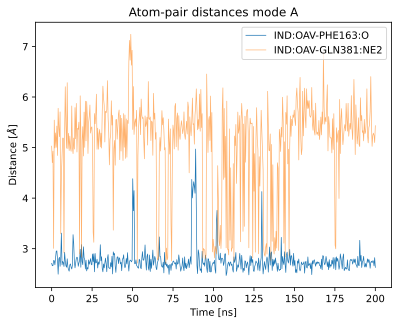

In [8]:
## atom-pairs distance analysis
FeN4  = [[Fe[0], i] for i in N4]
hbond1_d = md.compute_distances(traj_, np.array(hbond1).reshape([1, 2]))
hbond2_d = md.compute_distances(traj_, np.array(hbond2).reshape([1, 2]))
hbond3_d = md.compute_distances(traj_, np.array(hbond3).reshape([1, 2]))
FeON_d   = md.compute_distances(traj_, np.array(FeON).reshape([1, 2]))
FeO_d    = md.compute_distances(traj_, np.array(FeO).reshape([1, 2]))
FeS_d    = md.compute_distances(traj_, np.array(FeS).reshape([1, 2]))
FeN4_d   = md.compute_distances(traj_, np.array(FeN4))

# plot H bonds
plt.plot(time_, hbond1_d * 10, alpha=1, label='IND:OAV-PHE163:O')
plt.plot(time_, hbond2_d * 10, alpha=0.6, label='IND:OAV-GLN381:NE2')
plt.legend(loc="upper right")
plt.xlabel("Time [ns]")
plt.ylabel(r"Distance [$\AA$]")
plt.title("Atom-pair distances mode A")

Text(0.5, 1.0, 'Atom-pair distances mode A')

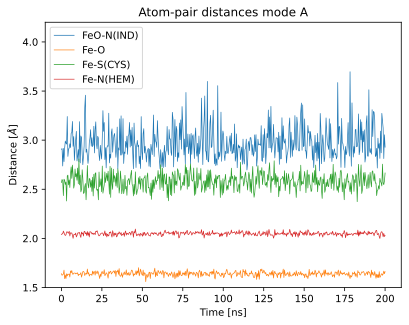

In [9]:
# plot FE1-reloated distances
plt.plot(time_, FeON_d  * 10, alpha=1, label='FeO-N(IND)')
plt.plot(time_, FeO_d   * 10, alpha=1, label='Fe-O')
plt.plot(time_, FeS_d   * 10, alpha=1, label='Fe-S(CYS)')
plt.plot(time_, np.average(FeN4_d, axis=1) * 10, alpha=1, label='Fe-N(HEM)')
plt.legend()
plt.ylim(1.5, 4.2)
plt.xlabel("Time [ns]")
plt.ylabel(r"Distance [$\AA$]")
plt.title("Atom-pair distances mode A")

## Get angles
Despite distances, it is also possible to compute 3-atom bending angles and 4-atom dihedral angles. These were mainly achieved by `md.compute_angles` and `md.compute_dihedrals`, respectively.
```python
md.compute_angles(traj, angle_indices, periodic=True, opt=True)
md.compute_dihedrals(traj, indices, periodic=True, opt=True)
```
Analogy to atom-pair distances, the atom indices for bending angles and dihedral angles should be arrays in $\mathbb{N}^{M\times 3}$ and $\mathbb{N}^{M\times 4}$, respectively.

Atom indices of the dihedral are [6269 6268 6271 6272].


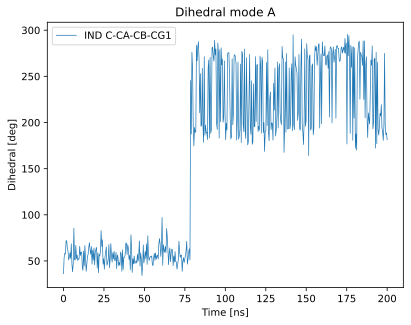

In [10]:
## dihedral analysis
# plot dihedral angle of C-CA-CB-CG1
dihe1   = np.concatenate([
    top.select("resname IND and name C"),
    top.select("resname IND and name CA"),
    top.select("resname IND and name CB"),
    top.select("resname IND and name CG1")]
)
dihe1_d = md.compute_dihedrals(traj_, np.array(dihe1).reshape([1, -1]))
plt.plot(time_, dihe1_d / np.pi * 180 % 360, label="IND C-CA-CB-CG1")
plt.xlabel("Time [ns]")
plt.ylabel("Dihedral [deg]")
plt.legend()
plt.title("Dihedral mode A")
print("Atom indices of the dihedral are {}.".format(dihe1))

## PCA analysis
Python is a good interface for statistical analysis. An example of performing PCA analysis on MD trajectory is presented in this tutorial. The heavy-atom trajectory of IND has been extracted and analyzed using PCA.

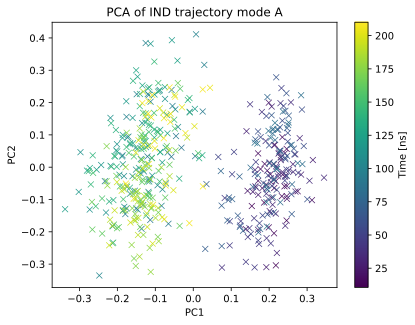

In [11]:
# PCA for IND
start_frame = 0
traj__INDtraj = traj_.xyz[:, IND_idx].reshape(traj_.xyz.shape[0], -1)
traj__INDtraj = traj__INDtraj[start_frame:, :]
traj__INDtraj = traj__INDtraj - traj__INDtraj[0, :]

pca = PCA(n_components=20)
reduced_coords = pca.fit_transform(traj__INDtraj)

# PCA scatter plot
# plt.scatter(reduced_coords[:, 0], reduced_coords[:, 1], marker='x', c=traj_.time[start_frame:])
plt.scatter(reduced_coords[:, 0], reduced_coords[:, 1], marker='x', c=traj_.time[start_frame:]/1000)
cbar = plt.colorbar()
cbar.set_label('Time [ns]')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of IND trajectory mode A")
plt.show()

[IND393-CG2, IND393-CG1, IND393-CG1, IND393-CG2, IND393-CG2, IND393-CB]

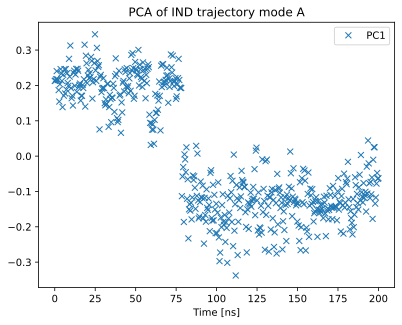

In [12]:
# function to get max contributors
def get_max_contribution_from_pca(P, n_pc, idx_, top_):
    n_comp = P.components_[n_pc]
    max_pos = [list(np.abs(n_comp)).index(i) for i in sorted(np.abs(n_comp), reverse=True)]
    max_pos_mapped = [k//3 for k in max_pos]
    max_pos_top    = [idx_[l] for l in max_pos_mapped]
    max_pos_atoms  = [list(top_.atoms)[i] for i in max_pos_top]
    return max_pos_atoms

# plot PCs
for i in range(1):
    plt.plot(time_[start_frame:], reduced_coords[:, i], 'x', label="PC{}".format(i+1))
plt.legend()
plt.xlabel("Time [ns]")
plt.title("PCA of IND trajectory mode A")
n_pc = 0
get_max_contribution_from_pca(pca, n_pc, IND_idx, top)[:6]

## Extract frames
It is also possible to extract frames as a single file, such as pdb, xyz, gro, netcfd, and etc.

In [13]:
# save the 499th frame as a single pdb file
frame_idx = 499
frame_    = traj_[frame_idx]
frame_    = frame_.remove_solvent() # (optional) remove water molecules
frame_.save_pdb("./6j83/6j83_dry_{}.pdb".format(frame_idx))